## Import libraries

In [50]:
import sys
import pandas as pd
import math
import numpy as np
import operator

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


## Load dataset

In [150]:
dataset_df_raw = pd.read_csv('../data/data/input1.txt', names=['id','x','y'], header=None, delimiter='\t')
dataset_df_sorted = dataset_df_raw.sort_values(['x'], ascending=[True])
dataset = dataset_df_sorted.to_dict('records')      # dataset[idx]

root = [i for i in range(len(dataset))]   # root[id]
adjs = [[] for _ in range(len(dataset))]  # adjs[id]

Eps = 15.0
MinPts = 22


## DBSCAN

In [142]:
def get_square_distance(p_0, p_1):
    return (p_0['x']-p_1['x'])*(p_0['x']-p_1['x']) + (p_0['y']-p_1['y'])*(p_0['y']-p_1['y'])


In [143]:
def get_root(pid):
    if root[pid] == pid:
        return root[pid]
    root[pid] = get_root(root[pid])
    return root[pid]


### 1. get adjs points

In [144]:
idx_start = 0
for p_now in dataset:
    # update idx_start
    for p_adj in dataset[idx_start:]:
        if p_now['x'] - p_adj['x'] > Eps:
            idx_start += 1
        else: 
            break
    # calc the num of pts
    for p_adj in dataset[idx_start:]:
        if p_adj['x'] - p_now['x'] > Eps:
            break
        if get_square_distance(p_now, p_adj) <= Eps * Eps:
            adjs[p_now['id']].append(p_adj)


### 2. clustering

In [145]:
for p_now in dataset:
    # check if core
    if len(adjs[p_now['id']]) >= MinPts:
        
        # reset root
        root_now = p_now['id']
        root[get_root(root_now)] = root_now
        root[root_now] = root_now
        
        # update adj points. to point to p_now
        for p_adj in adjs[p_now['id']]:
            root_adj = p_adj['id']
            if len(adjs[root_adj]) >= MinPts:
                root_adj = get_root(root_adj)
            root[root_adj] = root_now
    
            

## Check Result

In [146]:
# Define our own plot function
def scatter(x, labels, num_of_labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", num_of_labels))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    # 그래프 규격선, 여백공간 제거
    ax.axis('off') 
    ax.axis('tight')

    # text
    c_count={}
    for c in labels:
        try: c_count[c]+= 1
        except: c_count[c]=1

    txts = []
    for key in c_count.keys():
        if c_count[key]<30:
            continue
        
        # Add Label with txt type on plotting image
        xtext, ytext = np.median(x[labels == key, :], axis=0)
        txt = ax.text(xtext, ytext, str(key), fontsize=10)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=3, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)
    

### 1. normalize points and labels

In [147]:
points = dataset_df_raw[['x', 'y']].to_dict('records')
points = [[point['x'], point['y']] for point in points]
points = np.array(points)


In [148]:
for idx in range(len(root)):
     root[idx] = get_root(idx)

root = np.array(root)


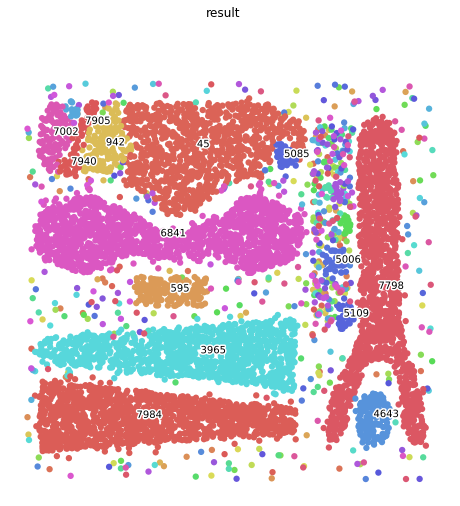

In [149]:
scatter(points, root, 8000, 'result')
